# Steps for Preprocessing Data



### 1.   Import the Data




> *   Read through Summary Pickle File 
*   Read through Case Data file and create dictionary with ordered lists of case text and associated summary
*   Create dataframe of with colums of the Case text and the Summary


### 2.   Build Batching Algorithm






> For each case text do the following:
*   Break into Paragraphs.
*   Check if the number of tokens in the paragraph is less than the minimum accepted paragraph length, if so, do not include it.
* Check if the number of tokens in the paragraph is more than the maximum accepted amount, if so, send that paragraph to the "Long Paragraph Function." (See Below)
* If the number of tokens in the paragraph is larger than the mimumum accepted amount and smaller than the maximum accepted amount, add the paragraph to the batch and go to the "Next Paragraph" fuction to see if the next paragraph can be added to the batch. (See Below)
* Pull all the batches together and create a list of batched text for the case.


> Long Paragraph Function:
* Calculate a target number of batches based on the length of the paragraph.
* Calculate target number of tokens per batch based on the number of batches and length of paragraph. (ensures a more even number of tokens per batch)
* Split the paragraph into sentences.
* If a sentence exists that is larger than the maximum allowed tokens, print that sentence but do not consider it for a batch.
* Otherwise, add sentences to the batch until reaching the target number of tokens per batch.
* Start a new batch and add sentences again until entire paragraph is accurately batched.




> Next Paragraph Function
* Looks at the length of the next paragraph, if it above the minimum token length and can be added to the previous paragraph without exceeding the maximum token length, it is added to the batch.

### 3. Run batching algorithm and save as a new column in the dataframe



### 4.   Break all data into sentences and label which sentences are in the summary.
> * Create helper functions to determine if two sentences are the same.
* Break batches into sentences, compare each sentences to the sentences in the gold summary, and label as 1 if the sentence exists in the gold summary
* Create a new dataframe storing sentence, batch, label and save as a pickle file.

### 5. Balance and Split Data
> * Use undersampling to have 2/3 labels of 0 and 1/3 label of 1.
* Split undersampled data into training and testing set (80% and 20% repspectively)
* Save training and testing as pickle files




### 1. Import the Data

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Read through Summary Pickle File

In [ ]:
import json
import pandas as pd
import pickle
import lzma

In [ ]:
import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
summary_file = '/content/gdrive/MyDrive/Thesis/Data/unique_citations_origin_dict.pickle'
all_opinion_data = '/content/gdrive/MyDrive/Thesis/Data/case_data.jsonl.xz'

In [ ]:
def read_through_pickle(file):
	'''
	This function just takes in a pickle file and reads it. Currently just returns the dictionary from my pickle file
	'''
	objects = []
	with (open(file, 'rb')) as openfile:
		while True:
			try:
				unique_citations = pickle.load(openfile)
				return unique_citations #This is just returning the file
				break
			except EOFError:
				return "There was an Error Loading Pickle File!!!"

In [ ]:
def make_summaries_sentences(summaries):
  '''
  This helper function inputs a list of summaries and returns a list of all the setences included in the summaries
  '''
  list_of_sentences = []
  for summ in summaries:
    sentences = sent_tokenize(summ)
    list_of_sentences += sentences

  return list_of_sentences

In [ ]:
id_to_sum = read_through_pickle(summary_file)

Read through Case Data file and create dictionary with ordered lists of case text and associated summary

In [ ]:
df_dict = {'case_text': [], 'summaries': []} #Will be {case_text: ____, summaries: _____}
count = 0
with lzma.open(all_opinion_data) as in_file:
  for i, line in enumerate(in_file):

    #This line controls how many cases I am going to be training with
    if count >= 350000:
      break
    
    else:

      cases = json.loads(str(line,'utf8'))
      case_id = cases['id']

      if case_id in id_to_sum:

        count += 1

        case_text = cases['casebody']['data']['opinions'][0]['text']
        case_summaries = [x[1] for x in id_to_sum[case_id]]

        df_dict['case_text'].append(case_text)
        df_dict['summaries'].append(make_summaries_sentences(case_summaries)) #Making sure the summaries consist of a list of individual sentences

  print("We are are analyzing ", count, " summaries")

We are are analyzing  5000  summaries


Create dataframe of with colums of the Case text and the Summary

In [ ]:
output_file = '/content/gdrive/MyDrive/Thesis/Data/case_data_no_batches.pickle'

In [ ]:
df = pd.DataFrame(data = df_dict)

with open(output_file, 'wb') as handle:   #Saving as a pickle file
  pickle.dump(df, handle)

### 2. Build Batching Algorithm

> For each case text do the following:
*   Break into Paragraphs.
*   Check if the number of tokens in the paragraph is less than the minimum accepted paragraph length, if so, do not include it.
* Check if the number of tokens in the paragraph is more than the maximum accepted amount, if so, send that paragraph to the "Long Paragraph Function." (See Below)
* If the number of tokens in the paragraph is larger than the mimumum accepted amount and smaller than the maximum accepted amount, add the paragraph to the batch and go to the "Next Paragraph" fuction to see if the next paragraph can be added to the batch. (See Below)
* Pull all the batches together and create a list of batched text for the case.

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 46.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 21.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 64.8 MB/s eta 0:00:00


In [ ]:
model_name = "bert-base-uncased" #Change this to use a different model
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [ ]:
def create_case_batches(case_text, min_length = 15, max_tokens = 512):

  #Break into paragraphs
  split_text = case_text.split('\n')

  batches = []

  used_indices = set() #Keeps track of the paragraphs we have already used

  for i in range(len(split_text)):

    single_batch = ''
    
    if i not in used_indices:
      paragraph = split_text[i]
      num_tokens = len(tokenizer.tokenize(paragraph))


      #Taking out the small paragraphs
      if num_tokens > min_length: 
        
        #Sending long paragraphs to a new batching algorithm
        if num_tokens > max_tokens:
          batches_from_long_p = batch_long_paragraphs(paragraph, num_tokens, max_tokens)
          batches += batches_from_long_p
        
        #Sending paragraphs that are less than the max to 
        else:
          single_batch += paragraph
          tokens_used = num_tokens
          updated_single_batch, used_indices = get_next_paragraph(split_text, i, single_batch, tokens_used, max_tokens, used_indices, min_length)
          batches.append(updated_single_batch)


  return batches

> Long Paragraph Function:
* Calculate a target number of batches based on the length of the paragraph.
* Calculate target number of tokens per batch based on the number of batches and length of paragraph. (ensures a more even number of tokens per batch)
* Split the paragraph into sentences.
* If a sentence exists that is larger than the maximum allowed tokens, print that sentence but do not consider it for a batch.
* Otherwise, add sentences to the batch until reaching the target number of tokens per batch.
* Start a new batch and add sentences again until entire paragraph is accurately batched.


In [ ]:
def batch_long_paragraphs(paragraph, num_tokens, max_tokens):
  '''
  The inputs for this helper function is a paragraph longer than the max number of tokens
  It will break up the paragraphs into groups of sentences as evenly spaced as possible
  '''
  num_batches = (num_tokens // max_tokens) + 1 # How many batches are needed for the paragraph
  target_batch_tokens = max_tokens // num_batches # How many tokens we are looking to have in each batch

  paragraph_sentences = sent_tokenize(paragraph)
  
  tokens_used = 0
  current_batch = ''

  longp_batches = []

  for i in range(len(paragraph_sentences)):

    sentence = paragraph_sentences[i]
    num_tokens_in_sent = len(tokenizer.tokenize(sentence))

    if num_tokens_in_sent > max_tokens:
      longp_batches += batch_long_sentences(sentence, num_tokens, max_tokens)
    
    else:

      if tokens_used + num_tokens_in_sent <= target_batch_tokens + 10: #Adding in a buffer
        tokens_used += num_tokens_in_sent
        current_batch += ' ' + sentence
      
      else:
        longp_batches.append(current_batch)
        tokens_used = num_tokens_in_sent
        current_batch = sentence

  return longp_batches

  > Long Sentence Function
* Same funcunality as the long paragraph function except that it breaks down words instead of sentences and continuously adds them.

In [ ]:
def batch_long_sentences(sentence, num_tokens, max_tokens):

  num_batches = (num_tokens // (max_tokens - 2)) + 1 # How many batches are needed for the paragraph
  target_batch_tokens = (max_tokens - 2) // num_batches # How many tokens we are looking to have in each batch

  sentence_words = word_tokenize(sentence)

  tokens_used = 0
  current_batch = ''

  longs_batches = []

  for i in range(len(sentence_words)):

      word = sentence_words[i]
      num_tokens_in_word = len(tokenizer.tokenize(word, add_special_tokens = False))

      if num_tokens_in_word > max_tokens - 2:
        print('THERE EXISTS A WORD LONGER THAN THE MAX TOKENS')
        print(word)
      
      else:

        if tokens_used + num_tokens_in_word <= target_batch_tokens + 5: #Adding in a buffer
          tokens_used += num_tokens_in_word
          current_batch += ' ' + word
        
        else:
          if tokens_used > 15:
            longs_batches.append(current_batch)
          tokens_used = num_tokens_in_word
          current_batch = word

  return longs_batches

  > Next Paragraph Function
* Looks at the length of the next paragraph, if it above the minimum token length and can be added to the previous paragraph without exceeding the maximum token length, it is added to the batch.

In [ ]:
def get_next_paragraph(split_text, i, single_batch, tokens_used, max_tokens, used_indices, min_tokens):
  '''
  Recursive Helper Function to add paragraphs until maxing out the tokens
  '''
  next_index = i+1

  #The current paragraph is the last one
  if next_index >= len(split_text): 
    return single_batch, used_indices

  next_paragraph = split_text[next_index]

  num_next_tokens = len(tokenizer.tokenize(next_paragraph))

  if num_next_tokens > min_tokens: #Getting rid of the small paragraphs

    #Making sure that adding the next paragraph keeps it below max_tokens tokens
    if tokens_used + num_next_tokens > max_tokens:
      return single_batch, used_indices

    #Adding the next paragraph to the batch and updating indices and tokens
    else:
      single_batch += ' ' + next_paragraph
      used_indices.add(next_index)
      tokens_used += num_next_tokens
      return get_next_paragraph(split_text, next_index, single_batch, tokens_used, max_tokens, used_indices, min_tokens)
  
  else:
    used_indices.add(next_index)
    return get_next_paragraph(split_text, next_index, single_batch, tokens_used, max_tokens, used_indices, min_tokens)

### 3.   Run Batching Algorithm and save as new column in dataframe

In [ ]:
df = pd.read_pickle('/content/gdrive/MyDrive/Thesis/Data/case_data_no_batches.pickle')

In [ ]:
case_texts = df['case_text']

Run the batching algorithm and save it into the dataframe

In [ ]:
all_512_batched_text = []
for case_text in case_texts:
  batched_text = create_case_batches(case_text, 15, 512)
  all_512_batched_text.append(batched_text)

Token indices sequence length is longer than the specified maximum sequence length for this model (537 > 512). Running this sequence through the model will result in indexing errors


In [ ]:
df['512_batches'] = all_512_batched_text

In [ ]:
output_file = '/content/gdrive/MyDrive/Thesis/Data/case_data_with_512_batches.pickle'
with open(output_file, 'wb') as handle:   #Saving as a pickle file
  pickle.dump(df, handle)

Visualizing the length of the batches

In [ ]:
all_tokens = []
for batches in all_512_batched_text:
  for batch in batches:
    num_tokens = len(tokenizer.tokenize(batch))
    all_tokens.append(num_tokens)

61410
Smallest Paragraph Length is 0
Max Paragraph Length is 512
Average Paragrah Length is 402.6370460836997


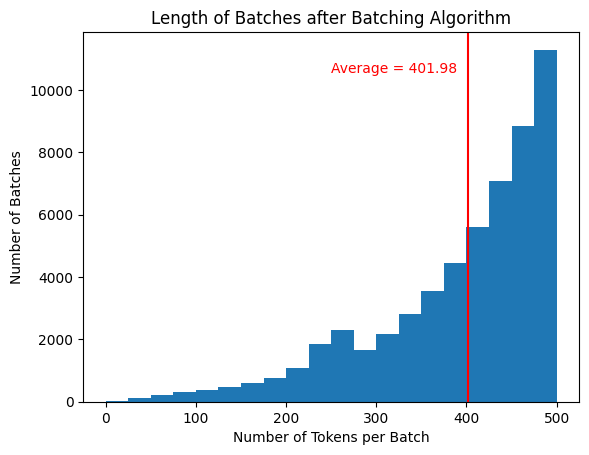

In [ ]:
from matplotlib import pyplot as plt
print(len(all_tokens))
max_length = max(all_tokens)
min_length = min(all_tokens)
print('Smallest Paragraph Length is', min_length)

bins = [x for x in range(min_length, max_length, int(max_length / 20))]
#print(bins)
plt.hist(all_tokens, bins = bins)
plt.axvline(x=401.978, color='red')
# Add a label to the line
plt.text(390, plt.ylim()[1]*0.9, 'Average = 401.98', ha='right', va='center', color='red')
plt.xlabel('Number of Tokens per Batch')
plt.ylabel('Number of Batches')
plt.title('Length of Batches after Batching Algorithm')
print("Max Paragraph Length is", max_length)

print('Average Paragrah Length is', sum(all_tokens) / len(all_tokens))

### 4.   Break all data into sentences and label which sentences are in the summary.

Create helper functions to determine if two sentences are the same.

In [ ]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
def get_cos_sim(summ, pred):
  '''
  Calculates the similarity between two sentences
  '''
  X = summ
  Y = pred

  X_list = word_tokenize(X) 
  Y_list = word_tokenize(Y)

  sw = stopwords.words('english') 
  l1 =[];l2 =[]

  # remove stop words from the string
  X_set = {w for w in X_list if not w in sw} 
  Y_set = {w for w in Y_list if not w in sw}

  # form a set containing keywords of both strings 
  rvector = X_set.union(Y_set) 
  for w in rvector:
      if w in X_set: l1.append(1) # create a vector
      else: l1.append(0)
      if w in Y_set: l2.append(1)
      else: l2.append(0)
  c = 0

  for i in range(len(rvector)):
        c+= l1[i]*l2[i]

  denominator = float((sum(l1)*sum(l2))**0.5)

  if denominator == 0:
    c = 0
    denominator = 1

  cosine = c / denominator

  return cosine

def is_sent_in_summ(s, summ):
  '''
  takes in a single sentence and a list of sentneces and detemrines if that single sentence is included in the list of sentences
  '''
  for summ in relevant_summ:
    if get_cos_sim(s, summ) >= 0.7:
      #print('1.', s)
      #print('2.', summ)
      return True
  return False

Break batches into sentences, compare each sentences to the sentences in the gold summary, and label as 1 if the sentence exists in the gold summary

In [ ]:
batched_df = pd.read_pickle('/content/gdrive/MyDrive/Thesis/Data/case_data_with_512_batches.pickle')

case_text = batched_df['case_text']
summaries = batched_df['summaries']
batches = batched_df['512_batches']

In [ ]:
def intermediate_save(input_sentences, input_texts, labels, i):
  '''
  saving the file so that we can save memory and if it crashes, we have something to work with
  '''
  input_dict = {'input_sentences': input_sentences, 'input_texts': input_texts, 'labels': labels}
  input_df = pd.DataFrame(data = input_dict)

  output_file_name = '/content/gdrive/MyDrive/Thesis/Data/'+str(i)+'_unbalanced_input_data.pickle'
  with open(output_file_name, 'wb') as handle:   #Saving as a pickle file
    pickle.dump(input_df, handle)

  input_sentences = []
  input_texts = []
  labels = []

  return input_sentences, input_texts, labels, output_file_name

In [ ]:
def analyze_batch(passage, relevant_summ):
  '''
  This helper function takes in a batch of text as a string and a list of "golden sentences" from a specific case
  and returns the sentences from the batch, a list of the batches to go with each sentence, a list of labels that say whether or not
  the sentence from the batch is a golden sentence, and a counter for the total number of golden sentences found
  '''

  input_sentences = []
  input_texts = []
  labels = []
  total_yes_labels = 0

  passage_sents = sent_tokenize(passage)
  input_sentences.append(passage_sents)

  for s in passage_sents:

    input_sentences.append(s) #adding the sentence to the new list of data
    input_texts.append(passage) #adding the passage to the new list of data

    if is_sent_in_summ(s, relevant_summ): #Use helper to calculate whether the sentence from the batch is included in the summary
        label = 1
        total_yes_labels += 1
    
    else:
        label = 0
    
    labels.append(label)
  
  labels.append(holder)
  
  return input_sentences, input_texts, labels, total_yes_labels

In [ ]:
import time

The below code creates a list of all sentences from every opinion, a list of the batches those sentences come from, and a label (0 or 1) as to whether that sentence is a golden sentence.

It also saves throughout the process in case of failures and tracks key statisitcs about the dataset we are using.

In [ ]:
input_sentences = []
input_texts = []
labels = []
saved_output_files = []
saved_file_names = []
output_file_name = None
list_file_name = '/content/gdrive/MyDrive/Thesis/Data/saved_file_names.pickle'

#Keeping track of passgaes, summaries and labels to know how many we have
unique_passage_count = 0
total_summary_sentences = 0
total_yes_labels = 0
time_for_labeling = 0

start_time = time.time()

for i in range(len(case_text)):

  passage_sents_holder = []
  sent_label_holder = []
  contains_summ_holder = []

  if i % 500 == 0 and i != 0:
    print(i,'/', len(case_text))

    #Do this step to make sure I have progress throughout labelling
    input_sentences, input_texts, labels, output_file_name = intermediate_save(input_sentences, input_texts, labels, i)
    saved_file_names.append(output_file_name)

    #Keeps track of all the saved files so I can use them for training
    with open(list_file_name, 'wb') as handle:   #Saving as a pickle file
      pickle.dump(saved_file_names, handle)

    print('New File Saved')

  relevant_summ = list(summaries[i]) #Pull summaries for each case
  relevant_batches = list(batches[i]) #Pull batches for each case

  unique_passage_count += len(relevant_batches)
  total_summary_sentences += len(relevant_summ)

  for passage in relevant_batches: #For each batch

    contains_summ = 0

    passage_sents = sent_tokenize(passage) #Extract the sentences from each batch

    passage_sents_holder.append(passage_sents) #Add sentences of

    batch_sents_label = [] 

    for s in passage_sents:

      input_sentences.append(s) #adding the sentence to the new list of data
      input_texts.append(passage) #adding the passage to the new list of data

      if is_sent_in_summ(s, relevant_summ): #Use helper to calculate whether the sentence from the batch is included in the summary
        label = 1
        total_yes_labels += 1
      
      else:
        label = 0

      labels.append(label)

input_sentences, input_texts, labels, output_file_name = intermediate_save(input_sentences, input_texts, labels, i)
saved_file_names.append(output_file_name)

output_name = '/content/gdrive/MyDrive/Thesis/Data/aggregation_data.pickle'
with open(output_name, 'wb') as handle:   #Saving as a pickle file
    pickle.dump(batched_df, handle)

end_time = time.time()
total_time = end_time - start_time
print("Time taken:", total_time, "seconds")
#print(time_for_labeling)

print('Number of Sentences:', len(input_sentences))
print('Number of Summary Sentences:', total_summary_sentences)
print('Number of yes labels:', total_yes_labels)
print('ABOVE TWO NUMBERS SHOULD BE ROUGHLY EQUAL')
print('Number of unique passages', unique_passage_count)

#print(len(saved_file_names))
#print(saved_file_names)
#print(pd.read_pickle(list_file_name))

500 / 5000
1000 / 5000
1500 / 5000
2000 / 5000
2500 / 5000
3000 / 5000
3500 / 5000
4000 / 5000
4500 / 5000
Time taken: 3905.8022491931915 seconds
5000
5000
5000
16
16
                                              case_text  \
0     SPOTTSWOOD W. ROBINSON, III, Circuit Judge:\nW...   
1     HAYS, Circuit Judge:\nThis is an appeal from a...   
2     McCREE, Circuit Judge.\nThis is an appeal from...   
3     PER CURIAM.\nThis appeal presents the sole iss...   
4     OPINION\nOn Petition for Rehearing\nBefore ELY...   
...                                                 ...   
4995  JOHN R. BROWN, Circuit Judge.\nThis appeal tes...   
4996  ENOCH, Circuit Judge.\nPlaintiff, Fuller Produ...   
4997  TUTTLE, Chief Judge.\nThe Secretary of Labor a...   
4998  DUNIWAY, Circuit Judge.\nThis appeal is from a...   
4999  BONE, Circuit Judge.\nAppellant is confined at...   

                                              summaries  \
0     [Accordingly, the standard for our review is n...   
1     

### 5. Balance and Split Data

Use undersampling to have 2/3 labels of 0 and 1/3 label of 1

In [ ]:
from sklearn.model_selection import train_test_split

def balance_and_split(data_name):
  '''
  Function that balances, splits and saves the data we gvie to it
  '''
  input_df = pd.read_pickle(data_name)

  pos_df = input_df[input_df.labels == 1]
  neg_df = input_df[input_df.labels == 0]

  num_negative_examples = len(neg_df)
  num_positive_examples = len(pos_df)

  sub_neg_df = neg_df.sample(len(pos_df)*2)

  reduced_neg_examples = len(sub_neg_df) #Tracking num of negative examples we now have
  balanced_df = pd.concat([pos_df, sub_neg_df], axis=0)

  total_num_examples = num_positive_examples + reduced_neg_examples

  train_bdf, test_bdf = train_test_split(balanced_df, test_size=0.2, random_state=42)

  train_file_name = data_name[:-28] + 'training_bdf.pickle'
  test_file_name = data_name[:-28] + 'testing_bdf.pickle'

  with open(train_file_name, 'wb') as handle:   #Saving as a pickle file
    pickle.dump(train_bdf, handle)


  with open(test_file_name, 'wb') as handle:   #Saving as a pickle file
    pickle.dump(test_bdf, handle)

  return train_file_name, test_file_name, total_num_examples, reduced_neg_examples, num_positive_examples, num_negative_examples

In [ ]:
name_of_saved_file_list = '/content/gdrive/MyDrive/Thesis/Data/saved_file_names.pickle'
saved_file_names = pd.read_pickle(name_of_saved_file_list)

list_of_training_files = []
list_of_testing_files = []
balanced_total_examples = 0
reduced_negative_examples = 0
original_positive_examples = 0
original_negative_examples = 0

for data_name in saved_file_names:
  train_file_name, test_file_name, total_num_examples, reduced_neg_examples, num_positive_examples, num_negative_examples = balance_and_split(data_name)

  list_of_training_files.append(train_file_name)
  list_of_testing_files.append(test_file_name)
  balanced_total_examples += total_num_examples
  reduced_negative_examples += reduced_neg_examples
  original_positive_examples += num_positive_examples
  original_negative_examples += num_negative_examples

print('Original Number of negative examples:', original_negative_examples)
print('Original Number of positive examples:', original_positive_examples)
print('Original Total Number of examples:', original_negative_examples + original_positive_examples)
print('Percentage of Examples that were negative:', round(original_negative_examples / (original_negative_examples + original_positive_examples), 3))

print('After balancing...')

print('Reduced Number of Negative examples:', reduced_negative_examples)
print('Total Number of examples:', balanced_total_examples)

print('Training Files:', list_of_training_files)
print('Testing Files:', list_of_testing_files)


Original Number of negative examples: 87294
Original Number of positive examples: 3000
Original Total Number of examples: 90294
Percentage of Examples that were negative: 0.967
After balancing...
Reduced Number of Negative examples: 6000
Total Number of examples: 9000
Training Files: ['/content/gdrive/MyDrive/Thesis/Data/100_training_bdf.pickle', '/content/gdrive/MyDrive/Thesis/Data/200_training_bdf.pickle', '/content/gdrive/MyDrive/Thesis/Data/300_training_bdf.pickle', '/content/gdrive/MyDrive/Thesis/Data/400_training_bdf.pickle', '/content/gdrive/MyDrive/Thesis/Data/499_training_bdf.pickle']
Testing Files: ['/content/gdrive/MyDrive/Thesis/Data/100_testing_bdf.pickle', '/content/gdrive/MyDrive/Thesis/Data/200_testing_bdf.pickle', '/content/gdrive/MyDrive/Thesis/Data/300_testing_bdf.pickle', '/content/gdrive/MyDrive/Thesis/Data/400_testing_bdf.pickle', '/content/gdrive/MyDrive/Thesis/Data/499_testing_bdf.pickle']
